# Model Visualization: Benchmark models
----------------
Benchmarks models shall be visualized in this notebook as a demo. The models which can be visualized here are:
1. Solar wind prediction using Support vector machines - **RBF SVM**, **Linear SVM** and **Polynomial SVM**. The models use solar wind data itself to perform the regression.
2. Solar wind prediction using **XGBoosting**. There are 2 classes of models - (i). Regression using solar wind data itself, and (ii). Embeddings obtained from GoogLeNet.
3. Solar wind prediction using Gradient boosting on GoogLeNet embeddings.

There are no _models_ per se for persistence and naive mean models, so their regressions shall simply be plotted at the end.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
from scipy.stats import chisquare
#import seaborn as sns
import sys
sys.path.append('../')
from helperfn.utils import *

In [2]:
from sklearn.externals import joblib
import xgboost as XGB
from sklearn.svm import SVR as Regressor
from sklearn import ensemble

In [3]:
n_out = 1
param = 11
param_stddev = param+3

We will need to know the following to load the model:
1. We will need the history and delay associated with the model. These are taken as input in the slider in the next cell, as parameters `history` and `delay` respectively.

2. The actual regression model as defined below:

    a. `SWSVM_RBF` for SVM using RBF kernel, and regression using SW data itself. 
    
    b. `SWSVM_Poly` for SVM using Polynomial kernel, and regression using SW data itself.
    
    c. `SWSVM_Linear` for SVM using Linear kernel, and regression using SW data itself.
    
    d. `XGBoost_SW` for XGBoost doing regression using SW data itself.
    
    e. `Persist` for a persistence from `T-history-delay` to `T`.
    
    f. `NaiveMean` for a mean value plotter.

Now then, go ahead, and enter the corresponding name in the cell below

In [8]:
'''
    Time to form the correlation matrix. Select the required model in model_path. 
    `path` can take the strings mentioned above.
    This is CV model.
'''
Correl = {'data':[],'error':[]}
MSE={'data':[],'error':[]}
redchi={'data':[],'error':[]}
ch_filter=211
for history in np.arange(1,5):
    Cor= {'data':[],'error':[]}
    mse1={'data':[],'error':[]}
    red={'data':[],'error':[]}
    for delay in np.arange(1,5):
        Co1=[]
        Re1=[]
        MS1=[]
        for cv in np.arange(1,6):
            model_to_be_used = "XGBoost_SW"
            '''
                We have the base path. Step-1: Look at the error and find minimum error.
            '''
            %run -i GUI_cv.py $history $delay $model_to_be_used $cv
            trainpaths = sorted(glob('../Data/CrossValidation'+str(ch_filter)+'/CV_'+str(cv)+'/Train/*.npy'))
            _,ytrain,ytrain_stddev = BifurcatedDataloader(trainpaths,param,param_stddev,[256,256,1],False)
            ymax =np.max(ytrain)-np.min(ytrain)
            ymin =np.min(ytrain)
            Prediction=NormalizeImage(Prediction,ymin,ymax)
            Error = NormalizeImage(Error,0.0,ymax)
            cor_b=[]
            #for i in np.arange(0,Prediction.shape[0],20-history-delay):
             #   cor_b.append(corr(Prediction[i:i+20-history-delay,0],Prediction[i:i+20-history-delay,1]))
            #Co1.append(np.mean(cor_b))
            Co1.append(corr(Prediction[:,0],Prediction[:,1]))
            
            c = chi2(Prediction[:,0],Prediction[:,1],Error*0.0+1)
            MS1.append(c)
            c = chi2(Prediction[:,0],Prediction[:,1],np.square(Error))
            Re1.append(c)
        Cor['data'].append(np.mean(np.asarray(Co1)))
        mse1['data'].append(np.mean(np.asarray(MS1)))
        red['data'].append(np.mean(np.asarray(Re1)))
        Cor['error'].append(np.std(np.asarray(Co1)))
        mse1['error'].append(np.std(np.asarray(MS1)))
        red['error'].append(np.std(np.asarray(Re1)))

    Correl['data'].append(np.asarray(Cor['data']))
    MSE['data'].append(np.asarray(mse1['data']))
    redchi['data'].append(np.asarray(red['data']))
    Correl['error'].append(np.asarray(Cor['error']))
    MSE['error'].append(np.asarray(mse1['error']))
    redchi['error'].append(np.asarray(red['error']))
    
Correl['data'] = np.asarray(Correl['data'])
MSE['data'] = np.asarray(MSE['data'])
redchi['data']=np.asarray(redchi['data'])
Correl['error'] = np.asarray(Correl['error'])
MSE['error'] = np.asarray(MSE['error'])
redchi['error']=np.asarray(redchi['error'])
#try:
#    FinalMat[model_to_be_used] = [Correl,CorrelB,RedCHI2]
#except:
#    FinalMat={model_to_be_used: [Correl,CorrelB,RedCHI2]}

'''
    We have a correlation matrix with cols = delays and rows = history. Next, we plot the matrices.
'''
        

'\n    We have a correlation matrix with cols = delays and rows = history. Next, we plot the matrices.\n'

In [9]:
print Correl

{'data': array([[0.74049914, 0.39150363, 0.15251532, 0.02542976],
       [0.76785315, 0.41568207, 0.18396502, 0.07069611],
       [0.7604936 , 0.42610506, 0.16222814, 0.06846263],
       [0.75510274, 0.39383861, 0.17019743, 0.0508104 ]]), 'error': array([[0.02112206, 0.04416534, 0.04883364, 0.07146342],
       [0.02743159, 0.0483766 , 0.0627915 , 0.03633582],
       [0.02290967, 0.04396615, 0.05702929, 0.04651206],
       [0.02492386, 0.03517466, 0.04772903, 0.04113531]])}


['MSE', 'RedMSE', 'Correlation']


Text(0,0.5,'History of Images')

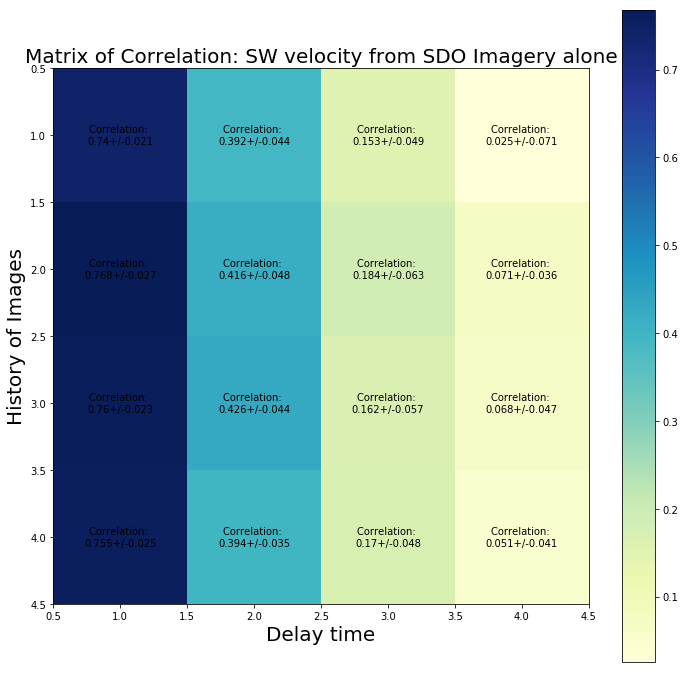

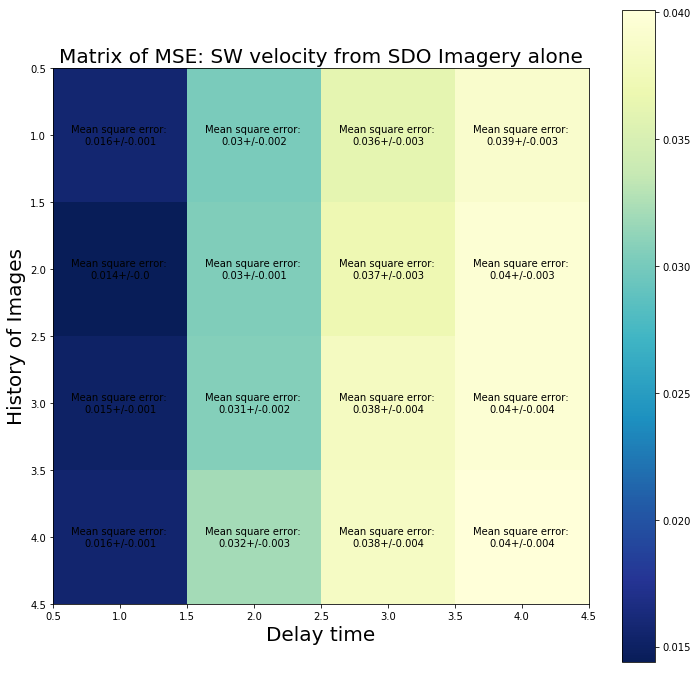

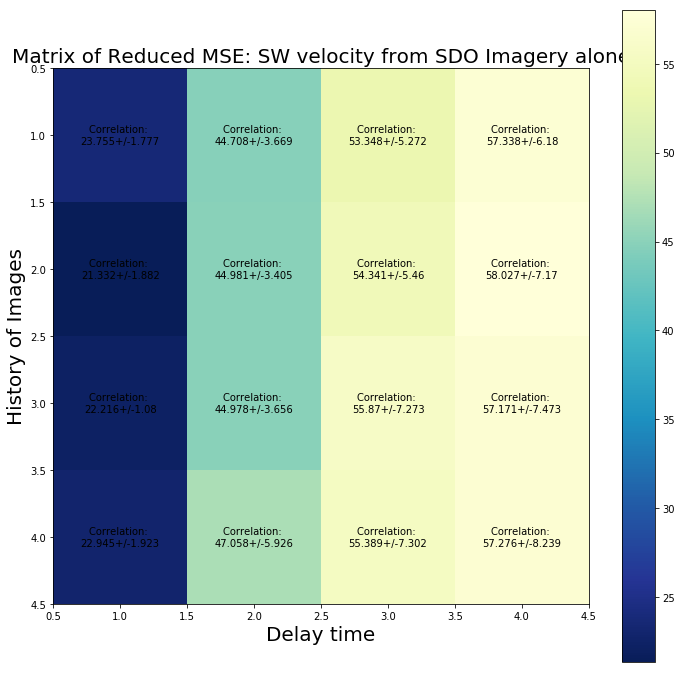

In [21]:
base='../Plots/Benchmark/'
path = base+'Matrix_Benchmark_'+str(model_to_be_used)+'.npy'
try:
    FinalCorrel = np.load(path).tolist()
    FinalCorrel['Correlation'] = Correl
    FinalCorrel['MSE'] = MSE
    FinalCorrel['RedMSE']=redchi
except:
    if not os.path.isdir(base):
        os.makedirs(base)
    FinalCorrel={'Correlation': Correl,'MSE': MSE,'RedMSE':redchi}
print FinalCorrel.keys()
np.save(path,FinalCorrel)

plt.figure(figsize = (12,12))
plt.title('Matrix of Correlation: SW velocity from SDO Imagery alone',fontsize=20)
plt.imshow(Correl['data'], cmap = 'YlGnBu', extent = [0.5,4.5,4.5,0.5])
for i in xrange(Correl['data'].shape[0]):
    for j in xrange(Correl['data'].shape[1]):
        plt.annotate('Correlation: \n' + str(np.around(Correl['data'][i,j],decimals = 3))+"+/-"+str(np.around(Correl['error'][i,j],decimals = 3)),xy = (j+1,i+1),horizontalalignment = 'center',verticalalignment = 'center')
plt.colorbar()
plt.xlabel('Delay time',fontsize=20)
plt.ylabel('History of Images',fontsize=20)
#plt.savefig("CrossValidation"+str(ch_filter)+'_Correl_WindNet.eps',dpi=300)
#plt.savefig("CrossValidation"+str(ch_filter)+'_Correl_WindNet.png',fmt='png',dpi=300)

plt.figure(figsize = (12,12))
plt.title('Matrix of MSE: SW velocity from SDO Imagery alone',fontsize=20)
plt.imshow(MSE['data'], cmap = 'YlGnBu_r', extent = [0.5,4.5,4.5,0.5])
for i in xrange(MSE['data'].shape[0]):
    for j in xrange(MSE['data'].shape[1]):
        plt.annotate('Mean square error: \n' + str(np.around(MSE['data'][i,j],decimals = 3))+"+/-"+str(np.around(MSE['error'][i,j],decimals = 3)),xy = (j+1,i+1),horizontalalignment = 'center',verticalalignment = 'center')
plt.colorbar()
plt.xlabel('Delay time',fontsize=20)
plt.ylabel('History of Images',fontsize=20)
#plt.savefig("CrossValidation"+str(ch_filter)+'_MSE_WindNet.eps',dpi=300)
#plt.savefig("CrossValidation"+str(ch_filter)+'_MSE_WindNet.png',fmt='png',dpi=300)

plt.figure(figsize = (12,12))
plt.title('Matrix of Reduced MSE: SW velocity from SDO Imagery alone',fontsize=20)
plt.imshow(redchi['data'], cmap = 'YlGnBu_r', extent = [0.5,4.5,4.5,0.5])
for i in xrange(redchi['data'].shape[0]):
    for j in xrange(redchi['data'].shape[1]):
        plt.annotate('Correlation: \n' + str(np.around(redchi['data'][i,j],decimals = 3))+"+/-"+str(np.around(redchi['error'][i,j],decimals = 3)),xy = (j+1,i+1),horizontalalignment = 'center',verticalalignment = 'center')
plt.colorbar()
plt.xlabel('Delay time',fontsize=20)
plt.ylabel('History of Images',fontsize=20)
#plt.savefig("CrossValidation"+str(ch_filter)+'_RedMSE_WindNet.eps',dpi=300)
#plt.savefig("CrossValidation"+str(ch_filter)+'_RedMSE_WindNet.png',fmt='png',dpi=300)

In [29]:
print redchi

{'data': array([[9.65698122e-05, 2.25320942e-04, 3.20435755e-04, 3.68979040e-04],
       [2.25320942e-04, 3.20435755e-04, 3.68979040e-04, 4.01219492e-04],
       [3.20435755e-04, 3.68979040e-04, 4.01219492e-04, 4.16196575e-04],
       [3.68979040e-04, 4.01219492e-04, 4.16196575e-04, 4.09836706e-04]]), 'error': array([[1.14912914e-05, 2.83406483e-05, 4.82268595e-05, 6.30947653e-05],
       [2.83406483e-05, 4.82268595e-05, 6.30947653e-05, 7.35295154e-05],
       [4.82268595e-05, 6.30947653e-05, 7.35295154e-05, 6.69079215e-05],
       [6.30947653e-05, 7.35295154e-05, 6.69079215e-05, 5.15514678e-05]])}


### Code ends here.